In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd

In [39]:
X = pd.read_csv('Xsvm.csv', header=None).to_numpy()
y = pd.read_csv('ysvm.csv', header=None).to_numpy()

# Q3

In [10]:
def rbf(x, y, sigma=0.5):
    return np.exp(-1*np.power(np.linalg.norm(x-y), 2)/(2*np.power(sigma, 2)))

def polynomial(x, y, d=2):
    return np.power(np.dot(x, y) + 1, d)

In [294]:
class SVM():
    def __init__(self, k=None):
        self.b = None
        self.b0 = None        
        self.k = k
    
    def _solve_primal(self, X, y):
        _, d = X.shape
        b = cp.Variable((d, 1))
        b0 = cp.Variable()
        
        constraints = [cp.multiply(y, (X@b + b0)) >= 1]
        cost = cp.norm(b, 2)
        problem = cp.Problem(cp.Minimize(cost), constraints)
        problem.solve()
        return b.value, b0.value, problem.value
        
    def _solve_dual(self, X, y):
        N, d = X.shape
        lam = cp.Variable((N, 1))
        
        constraints = [
            lam >= 0,
            y.T@lam == 0
        ]
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i, j] = y[i, 0]*y[j, 0]*self.k(X[i], X[j])
        
#         K = cp.atoms.affine.wraps.psd_wrap(K)
#         print(K)
        cost = 0.5*cp.quad_form(lam, K) - cp.sum(lam)
        
        problem = cp.Problem(cp.Minimize(cost), constraints)
        problem.solve();
        
        b = X.T@lam.value
        b0 = constraints[1].dual_value[0, 0]
        return b, b0, problem.value
    
    def predict(self, X):
        if self.k is None:
            y_pred = (X@self.b + self.b0) - 1 >= 0
        else:
            K = np.array([self.k(X[i], self.b[:, 0]) for i in range(X.shape[0])])
            y_pred = (K + self.b0) - 1 >= 0
            y_pred = y_pred.reshape(-1, 1)
        return 2*y_pred - 1
    
    def fit(self, X, y):
        if self.k is None:
            self.b, self.b0, cost = self._solve_primal(X, y)
        else:
            self.b, self.b0, cost = self._solve_dual(X, y)
        
        if self.b is None:
            print('Infeasible problem')
            return
        
        y_pred = self.predict(X)
        print(y_pred, y)
        acc = 100*np.sum(y_pred == y)/y.shape[0]
        print('Training Accuracy:- {}%'.format(np.round(acc, 2)))
        return self.b, self.b0, cost
    
    

# Q4

In [274]:
cls = SVM()
cls.fit(X, y);

l = np.array([[1.9, 0.4], [0.9, 0.9], [1.4, 1.5], [0.01, 0.005]])
pred = cls.predict(l)[:, 0]

print('\nPredictions')
for x, p in zip(l, pred):
    print('{} -> {}'.format(x, p))

Training Accuracy:- 100.0%

Predictions
[1.9 0.4] -> 1
[0.9 0.9] -> 1
[1.4 1.5] -> 1
[0.01  0.005] -> -1


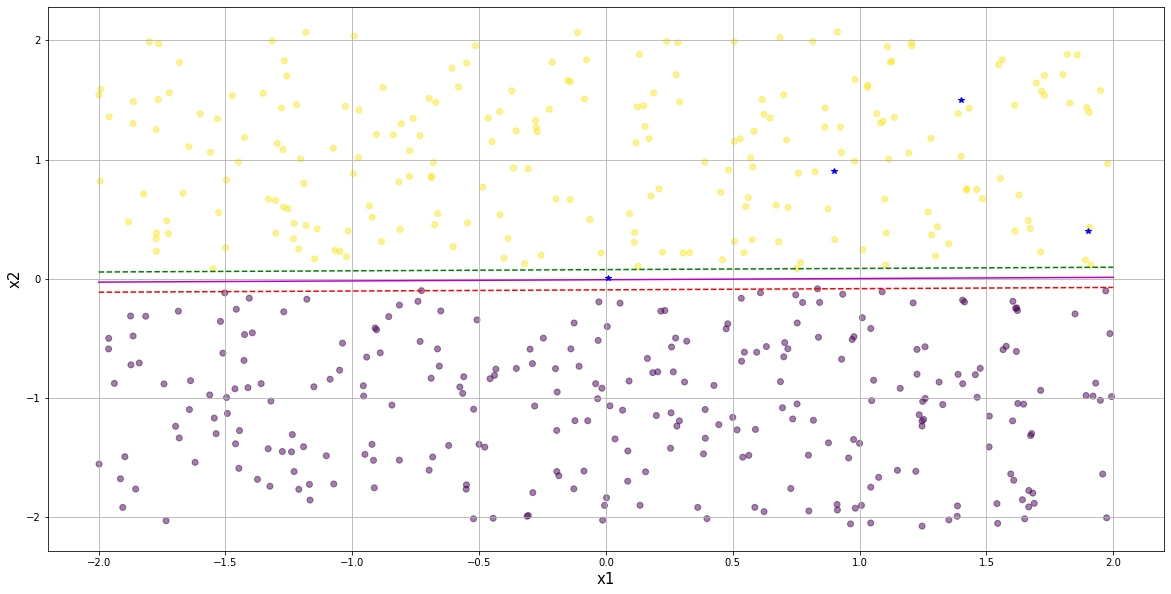

In [275]:
x = np.linspace(-2, 2, 50)
y_pred = -1*(cls.b[0, 0]*x + cls.b0)/cls.b[1, 0]

plt.figure(figsize=(20, 10))

plt.plot(x, y_pred, 'm')
plt.plot(x, y_pred+1/(cls.b[1, 0]), '--g')
plt.plot(x, y_pred-1/(cls.b[1, 0]), '--r')
for i in l:
    plt.plot(i[0], i[1], '*b')
plt.scatter(X[:, 0], X[:, 1], c=y+1, marker='o', alpha=0.5)
plt.xlabel('x1', fontsize=15);
plt.ylabel('x2', fontsize=15);
plt.xticks(fontsize=10);
plt.grid()
plt.yticks(fontsize=10);

# Q5

In [280]:
var = 1e-12
N = 0

l = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
X_xor = l
l_y = np.array([[-1], [1], [1], [-1]])
y_xor = l_y

for i in range(N//4):
    for j, k in zip(l, l_y):
        X_xor = np.vstack((X_xor, np.random.multivariate_normal(j, [[var, 0], [0, var]])))
        y_xor = np.vstack((y_xor, [k]))


## Failure of Linear SVM

In [295]:
clf = SVM()
clf.fit(X_xor, y_xor);

Infeasible problem


## Applying kernel
$k(\overline{x}, \overline{y}) = x_1y_1 + x_2y_2 + x_1y_1x_2y_2$

In [300]:
def xor_kernel(x, y):
    x_1, x_2 = x[0], x[1]
    y_1, y_2 = y[0], y[1]
    return x_1*y_1 + x_2*y_2 + 2*x_1*y_1*x_2*y_2

In [301]:
clf = SVM(xor_kernel)
clf.fit(X_xor, y_xor);

[[-1]
 [ 1]
 [ 1]
 [ 1]] [[-1]
 [ 1]
 [ 1]
 [-1]]
Training Accuracy:- 75.0%


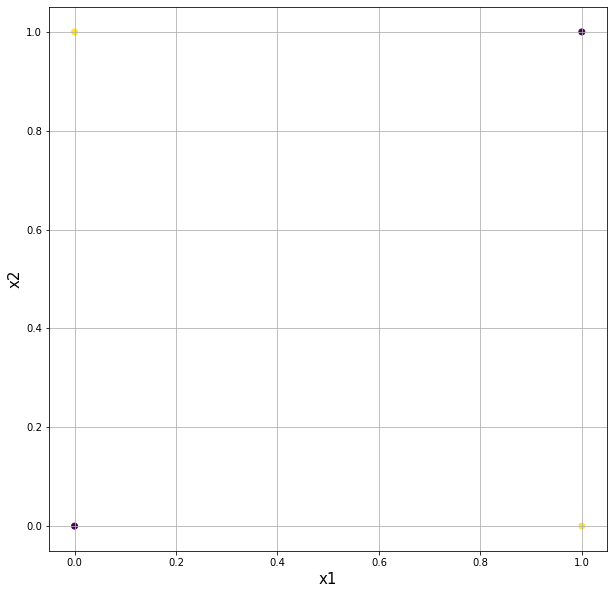

In [298]:
# x = np.linspace(-2, 2, 50)
# y_pred = -1*(cls.b[0, 0]*x + cls.b0)/cls.b[1, 0]

plt.figure(figsize=(10, 10))

# plt.plot(x, y_pred, 'm')
# plt.plot(x, y_pred+1/(cls.b[1, 0]), '--g')
# plt.plot(x, y_pred-1/(cls.b[1, 0]), '--r')
# for i in l:
#     plt.plot(i[0], i[1], '*b')
plt.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor+1, marker='o', alpha=1)
plt.xlabel('x1', fontsize=15);
plt.ylabel('x2', fontsize=15);
plt.grid()
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);